In [1]:
import re
import torch
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics.pairwise import cosine_similarity

c:\Users\KSKS\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def sentence_splitter():
    with open("../content.txt", "r") as file:
        content = file.read()
        sentences = re.split(r"(?<=[.!?])\s+", content)
    return sentences

In [3]:
sentences = sentence_splitter()
initial_chunks = [{"index": i, "chunk": sentence} for i, sentence in enumerate(sentences)]
initial_chunks

[{'index': 0,
  'chunk': 'Retrieval-Augmented Generation (RAG) is a groundbreaking technique in natural language processing that combines the strengths of retrieval-based and generative models to create a system capable of producing highly accurate and contextually relevant text.'},
 {'index': 1,
  'chunk': 'By leveraging both retrieval and generation, RAG models address many of the limitations of traditional models, offering a more robust and flexible approach to various tasks.'},
 {'index': 2,
  'chunk': 'The process begins with the retrieval of relevant documents or passages from a large corpus.'},
 {'index': 3,
  'chunk': 'The retrieval component typically uses dense embeddings, which are vector representations learned to capture the semantic meaning of the text.'},
 {'index': 4,
  'chunk': 'These embeddings allow the model to measure the similarity between the input query and potential documents, even when they do not share exact keywords.'},
 {'index': 5,
  'chunk': 'Dense retrie

In [4]:
def calculate_embeddings(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors = "pt", truncation = True, padding = True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim = 1).squeeze().numpy()

In [5]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

c:\Users\KSKS\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
for i in range(len(initial_chunks)):
    embedding = calculate_embeddings(initial_chunks[i]["chunk"], model, tokenizer)
    initial_chunks[i]["embedding"] = embedding

In [7]:
def calculate_cosine_distances(initial_chunks):
    distances = []
    for i in range(len(initial_chunks) - 1):
        cur_embedding = initial_chunks[i]["embedding"]
        next_embedding = initial_chunks[i + 1]["embedding"]

        similarity = cosine_similarity([cur_embedding], [next_embedding])[0][0]
        distance = 1 - similarity

        distances.append(distance)
        initial_chunks[i]["distance_to_next"] = distance
        
    return distances

In [8]:
distances = calculate_cosine_distances(initial_chunks)

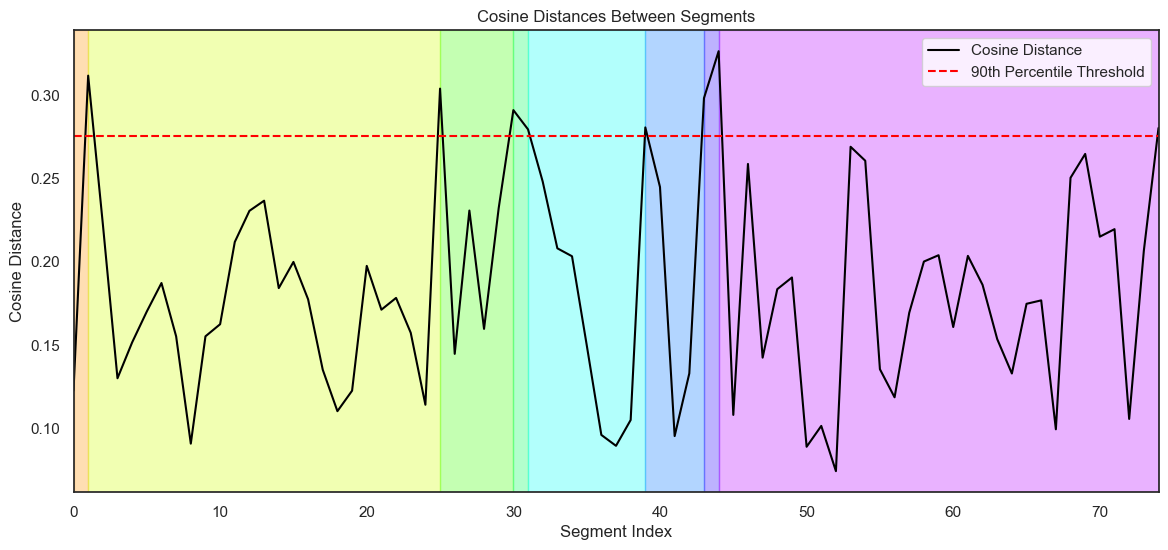

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def visualize_cosine_distances_with_thresholds_multicolored(
    cosine_distances, 
    threshold_percentile=90
):
    threshold_value = np.percentile(cosine_distances, threshold_percentile)

    crossing_points = [0]  
    crossing_points += [i for i, distance in enumerate(cosine_distances) if distance > threshold_value]
    crossing_points.append(len(cosine_distances))  

    plt.figure(figsize=(14, 6)) 

    sns.lineplot(
        x=range(len(cosine_distances)),
        y=cosine_distances,
        color="black",
        label="Cosine Distance",
    )

    plt.axhline(
        y=threshold_value,
        color="red",
        linestyle="--",
        label=f"{threshold_percentile}th Percentile Threshold",
    )

    colors = sns.color_palette("hsv", len(crossing_points) - 1)  
    for i in range(len(crossing_points) - 1):
        plt.axvspan(crossing_points[i], crossing_points[i + 1], color=colors[i], alpha=0.3)

    plt.title("Cosine Distances Between Segments")
    plt.xlabel("Segment Index")
    plt.ylabel("Cosine Distance")
    plt.legend()

    plt.xlim(0, len(cosine_distances) - 1)

    plt.show()

    return crossing_points

crossing_points = visualize_cosine_distances_with_thresholds_multicolored(distances)

In [28]:
threshold_percentile = 90
threshold_value = np.percentile(distances, threshold_percentile)

crossing_points = [0]
crossing_points += [i for i, distance in enumerate(distances) if distance > threshold_value]
len(crossing_points)

9

In [29]:
crossing_points

[0, 1, 25, 30, 31, 39, 43, 44, 74]

In [30]:
final_chunks = []

for point in range(len(crossing_points) - 1):
    current_chunk = ""
    for i in range(crossing_points[point], crossing_points[point + 1]):
        current_chunk += initial_chunks[i]["chunk"] + " "
    final_chunks.append(current_chunk)

In [31]:
final_chunks

['Retrieval-Augmented Generation (RAG) is a groundbreaking technique in natural language processing that combines the strengths of retrieval-based and generative models to create a system capable of producing highly accurate and contextually relevant text. ',
 'By leveraging both retrieval and generation, RAG models address many of the limitations of traditional models, offering a more robust and flexible approach to various tasks. The process begins with the retrieval of relevant documents or passages from a large corpus. The retrieval component typically uses dense embeddings, which are vector representations learned to capture the semantic meaning of the text. These embeddings allow the model to measure the similarity between the input query and potential documents, even when they do not share exact keywords. Dense retrieval models, often based on transformer architectures like BERT, excel at finding contextually relevant information. Once the most relevant documents are retrieved, 

In [33]:
def calculate_similarity(embedding1, embedding2):
    similarity = cosine_similarity([embedding1], [embedding2])
    return similarity[0][0]

In [34]:
def test_with_model(chunks, user_query, top_k, model_name = "bert-base-uncased"):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    embeddings = []
    for i in range(len(final_chunks)):
        embedding = calculate_embeddings(final_chunks[i], model, tokenizer)
        embeddings.append(embedding)

    user_query_embedding = calculate_embeddings(user_query, model, tokenizer)
    scores = {i: calculate_similarity(user_query_embedding, embedding) for i, embedding in enumerate(embeddings)}
    sorted_chunks = sorted(scores.items(), key = lambda item: item[1])[:top_k]
    
    print("Matching chunks:\n")
    for chunk in sorted_chunks:
        print(chunks[chunk[0]], "\n")

In [25]:
test_with_model(final_chunks, user_query="What is rag?", top_k=1)

Matching chunks:

RAG models have shown significant promise in a variety of applications. In knowledge-intensive tasks, RAG models can provide accurate and contextually relevant answers to complex questions by retrieving and synthesizing information from multiple sources. In summarization tasks, RAG models can generate concise and informative summaries by retrieving the most relevant passages and synthesizing them into a coherent summary. The flexibility and versatility of RAG models also make them well-suited for tasks like content generation, personalized content delivery, and conversational AI. In conversational AI, RAG models can enhance the quality of interactions by retrieving relevant information and generating responses that are both accurate and engaging. This can be particularly useful in customer support, where the system needs to provide helpful responses to a wide range of queries. By retrieving relevant information from a vast corpus and generating contextually appropriat